Out: torch.Size([1, 2, 512, 512])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

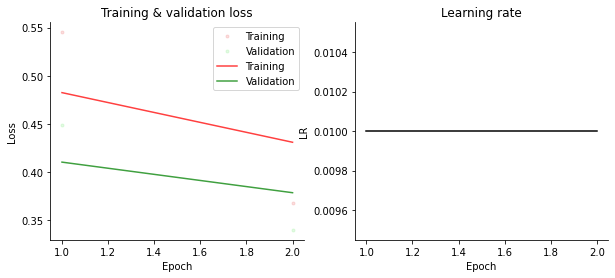

x = shape: torch.Size([3, 3, 128, 128]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([3, 128, 128]); class: tensor([0, 1]); type: torch.int64
Out: torch.Size([1, 2, 512, 512])


Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

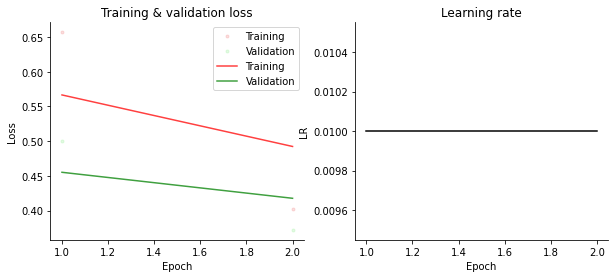

In [2]:
import pathlib
import torch
import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize
from inference import predict
from customdatasets import SegmentationDataSet1
from transformations import re_normalize
from skimage.io import imread
from skimage.transform import resize
import os
from transformations import (
    ComposeDouble,
    AlbuSeg2d,
    FunctionWrapperDouble,
    normalize_01,
    create_dense_target,
)
from unet import UNet
from trainer import Trainer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

"""
PART 1: Data
"""

# root directory
root = pathlib.Path.cwd() / "Carvana"

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / "Input")
targets = get_filenames_of_path(root / "Target")

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(128, 128, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(128, 128),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True
)

# dataset training
dataset_train = SegmentationDataSet1(
    inputs=inputs_train, targets=targets_train, transform=transforms_training
)

# dataset validation
dataset_valid = SegmentationDataSet1(
    inputs=inputs_valid, targets=targets_valid, transform=transforms_validation
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=3, shuffle=True, num_workers=0)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=3, shuffle=True, num_workers=0)


x, y = next(iter(dataloader_training))

print(f"x = shape: {x.shape}; type: {x.dtype}")
print(f"x = min: {x.min()}; max: {x.max()}")
print(f"y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}")

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)


# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

"""
PART 2: Model
"""

num_classes = 2
model = UNet(
    in_channels=3,
    out_channels=num_classes,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
)

x = torch.randn(size=(1, 3, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f"Out: {out.shape}")

"""
PART 3: TRAINING
"""

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=None,
    epochs=2,
    epoch=0,
    notebook=True,
)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

from visual import plot_training

fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)